# Training to Deployment with PyTorch Lightning

In [1]:
# !git clone https://github.com/Horea94/Fruit-Images-Dataset.git

## Settings

In [ ]:
# Path to directory with data, with one subdirectory per category
DATADIR = "Fruit-Images-Dataset"
# Shape to resize the images to before propagating through the network. For MobileNet this is (224,224).
IMAGE_SHAPE = (224, 224)
# Descriptive name of the model. Saved models will be named MODELNAME.onnx etc.
MODELNAME = "fruit"

## Imports

In [2]:
import copy
import os
import random
import subprocess
import time
import warnings
from operator import itemgetter
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import sklearn.metrics as skm
import torch
import torchmetrics as metrics
import torchvision
from openvino.inference_engine.ie_api import IECore
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset

## Create dataset

In [3]:
class BaseDataset(TorchDataset):
    """
    DataLoader for image data that is stored in a directory per category. For example, for
    categories _rose_ and _daisy_, rose images are expected in data_source/rose, daisy images
    in data_source/daisy.
    """

    def __init__(self, data_source, split, transforms=None):
        """
        :param data_source: path to data directory
        """
        self.data_source = Path(data_source) / split
        assert self.data_source.is_dir(), f"{self.data_source} is not a directory"
        self.dataset = [p for p in self.data_source.glob("**/*") if p.suffix in (".png", ".jpg")]
        self.class_names = sorted(
            [item.name for item in Path(self.data_source).iterdir() if item.is_dir()]
        )
        self.num_classes = len(self.class_names)
        self.split = split

    def __len__(self):
        """
        Returns the number of elements in the dataset
        """
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Get item from self.dataset at the specified index.
        """
        if index >= len(self):
            raise IndexError
        filepath = self.dataset[index]
        annotation = self.class_names.index(filepath.parent.name)
        image = self._read_image(str(filepath))
        return torch.as_tensor(image), torch.as_tensor(annotation)

    def _read_image(self, filepath):
        """
        Read image at dataset[index] to memory, resize, convert to BGR and to network shape

        :param index: dataset index to read
        :return ndarray representation of image batch
        """
        image = cv2.imread(filepath)[:, :, (2, 1, 0)]
        image = cv2.resize(image, IMAGE_SHAPE).astype(np.float32)
        return image.transpose(2, 0, 1)

In [4]:
class DataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str, batch_size):
        print(data_dir)
        super().__init__()
        self.batch_size = batch_size
        self.data_dir = data_dir
        # self.setup()

    def setup(self, stage=None):
        self.dataset_train = BaseDataset(self.data_dir, "Training")
        self.dataset_val = BaseDataset(self.data_dir, "Test")

    def train_dataloader(self):
        return DataLoader(
            self.dataset_train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0,
            drop_last=False,
        )

    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=self.batch_size, num_workers=0)

## Define LightningModel

In [5]:
class InceptionLightningModel(pl.LightningModule):
    def __init__(self, num_classes, aux_logits):
        super().__init__()
        self.model = torchvision.models.mobilenet_v2(pretrained=True)
        self.num_classes = num_classes
        self.aux_logits = aux_logits

        # Replace last layer with classifier for number of classes in dataset
        num_ftrs = self.model.classifier[1].in_features
        self.model.classifier[1] = torch.nn.Linear(
            in_features=num_ftrs, out_features=num_classes, bias=True
        )
        self.metric = metrics.Accuracy()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.long()
        y_hat = self(x)
        loss = torch.nn.CrossEntropyLoss()(y_hat, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        p = self(x)
        ytrue = y.long().flatten()
        ypred = torch.argmax(p, dim=1).long().flatten()
        score = self.metric(ytrue.cpu(), ypred.cpu())
        return {
            "metric": score,
        }

    def validation_epoch_end(self, validation_step_outputs):
        metric_mean = torch.stack([x["metric"] for x in validation_step_outputs]).mean()
        self.log("validation_accuracy", metric_mean, prog_bar=True, logger=False)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

## Train

### Visualize the train dataset

Show the train dataset to check that the data looks okay. 

In [6]:
data = DataModule(DATADIR, 32)
data.setup()

num = min(len(data.dataset_train), 10)
indices = random.sample(range(len(data.dataset_train)), num)
data_subset = itemgetter(*indices)(data.dataset_train)

Fruit-Images-Dataset


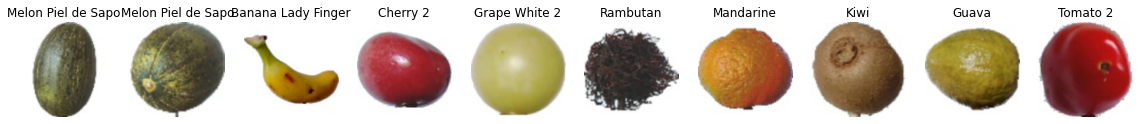

In [7]:
fig, ax = plt.subplots(1, num, figsize=(20, 4), squeeze=False)
for i, (image, label) in enumerate(data_subset):
    ax[0, i].imshow(image.short().permute(1, 2, 0).cpu())
    ax[0, i].set_title(f"{data.dataset_val.class_names[label]}")
    ax[0, i].axis("off")

plt.show()

### Create and train the model

We train the model for five epochs. Since the model uses weights pretrained on ImageNet, this should give good performance if the data is similar to ImageNet data. For other data, you will probably need to increase the `num_epochs` parameter of PyTorch Lightning's `Trainer`. Set `gpus` to `0` if you do not want to use a GPU for training.

In [8]:
logger = TensorBoardLogger("tb_logs", name=MODELNAME)
checkpoint_callback = ModelCheckpoint(monitor="validation_accuracy", mode="max", save_top_k=1)
# Ignore PyTorch Lightning warnings about possible improvements
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
model = InceptionLightningModel(num_classes=data.dataset_train.num_classes, aux_logits=False)
USE_CUDA = torch.cuda.is_available()
trainer = pl.Trainer(
    max_epochs=1,
    gpus=1 if USE_CUDA else 0,
    logger=logger,
    precision=16 if USE_CUDA else 32,
    limit_train_batches=0.2,
    limit_val_batches=0.2,
    callbacks=[checkpoint_callback],
    fast_dev_run=False,  # set to True to quickly test the Lightning model
)

trainer.fit(model=model, datamodule=data)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/lena/code/openvino_notebooks_helena/openvino_env/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | model  | MobileNetV2 | 2.4 M 
1 | metric | Accuracy    | 0     
---------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
4.783     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Test the model on the validation dataset

The PyTorch Lightning `.validate()` method loads the best checkpoint (the checkpoint with the highest accuracy) into the model and returns the accuracy over the validation dataset. 

In [9]:
trainer.validate(model, datamodule=data, ckpt_path="best")

Restoring states from the checkpoint path at tb_logs/fruit/version_10/checkpoints/epoch=0-step=422.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at tb_logs/fruit/version_10/checkpoints/epoch=0-step=422.ckpt


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'validation_accuracy': 0.9993350505828857}
--------------------------------------------------------------------------------


[{'validation_accuracy': 0.9993350505828857}]

#### Show predictions on validation dataset

Metrics do not always tell the whole story. Visualizing the results also helps to understand the quality of the model

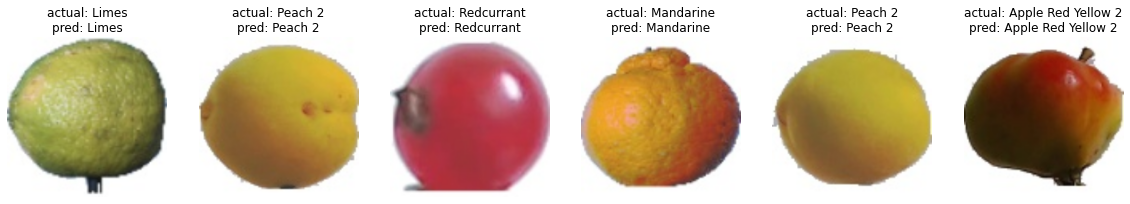

In [10]:
viz_dataset = data.dataset_val
num = min(len(viz_dataset), 6)
indices = np.random.choice(range(len(viz_dataset)), num, replace=False)

fig, ax = plt.subplots(1, num, figsize=(20, 5), squeeze=False)
model.eval().cpu()
for i, index in enumerate(indices):
    image, label = viz_dataset[index]
    image = torch.as_tensor(image)

    with torch.no_grad():
        prediction = model(image.unsqueeze(0))
    predicted_label = torch.argmax(prediction)
    predicted_label_name = viz_dataset.class_names[predicted_label]
    actual_label_name = viz_dataset.class_names[label]
    # image = inverse_normalize(image) * 255
    ax[0, i].imshow(image.permute(1, 2, 0).short().cpu())
    ax[0, i].set_title(f"actual: {actual_label_name}\npred: {predicted_label_name}")
    ax[0, i].axis("off")
plt.show()

## Create OpenVINO Model

To create an OpenVINO IR model, we convert the PyTorch model to ONNX, and then use the OpenVINO model optimizer to convert the ONNX model to an IR model.

In [11]:
modelname_xml = MODELNAME + ".xml"
modelname_onnx = MODELNAME + ".onnx"

### Create ONNX model

In [12]:
dummy_input = torch.randn(1, 3, 299, 299)
torch.onnx.export(model.model.cpu(), dummy_input, modelname_onnx, opset_version=11)

### Create OpenVINO IR model

In [13]:
subprocess.run(
    [
        "mo",
        "--model_name",
        MODELNAME,
        "--input_model",
        modelname_onnx,
        "--input_shape",
        f"{(1,3,*IMAGE_SHAPE)}",
        "--output_dir",
        os.path.abspath(os.curdir),
        "--data_type",
        "FP16",
    ],
)

CompletedProcess(args=['mo', '--model_name', 'fruit', '--input_model', 'fruit.onnx', '--input_shape', '(1, 3, 224, 224)', '--output_dir', '/home/lena/code/openvino_notebook_demos/openvino-planets', '--data_type', 'FP16'], returncode=0)

### Do inference and show predictions

We create two helper functions, `load_to_IE` and `do_inference` to load the IR model and perform inference. 

We then load the model, do inference on the test dataset, and show the results.

In [14]:
def load_to_IE(modelname_xml):
    """
    Load a given IR model to Inference Engine

    :param modelname_xml: Filename to IR model XML file. The accompanying IR bin file is expected to be in the same directory.
    """
    ie = IECore()  # Load the Inference Engine API
    net = ie.read_network(model=modelname_xml, weights=modelname_xml.replace("xml", "bin"))
    exec_net = ie.load_network(
        network=net, device_name="CPU"
    )  # Load the network to the inference engine
    return exec_net


def do_inference(exec_net, image):
    input_blob = next(iter(exec_net.input_info))
    output_key = next(iter(exec_net.outputs))
    return exec_net.infer({input_blob: image})[output_key]


openvino_model = load_to_IE(modelname_xml)

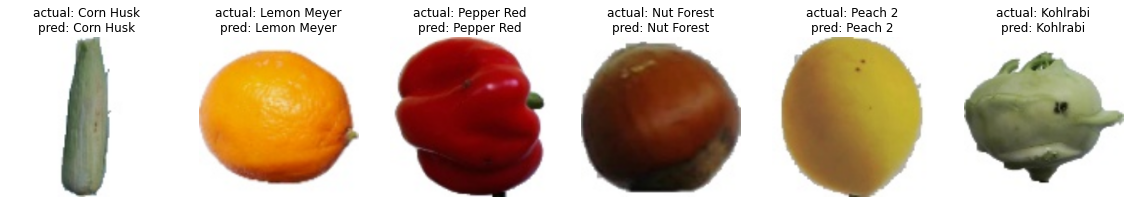

In [15]:
viz_dataset = data.dataset_val
num = min(len(viz_dataset), 6)
indices = np.random.choice(range(len(viz_dataset)), num, replace=False)

fig, ax = plt.subplots(1, num, figsize=(20, 5), squeeze=False)
for i, index in enumerate(indices):
    image, label = viz_dataset[index]
    input_image = image.unsqueeze(0).float().numpy().copy()
    prediction = do_inference(openvino_model, input_image)
    predicted_label = np.argmax(prediction)
    predicted_label_name = viz_dataset.class_names[predicted_label]
    actual_label_name = viz_dataset.class_names[label]

    # display_image = inverse_normalize(image) * 255
    ax[0, i].imshow(image.permute(1, 2, 0).short().cpu())

    ax[0, i].set_title(f"actual: {actual_label_name}\npred: {predicted_label_name}")

    ax[0, i].axis("off")
plt.show()

## Compare PyTorch and OpenVINO accuracy and speed

#### Compute accuracy for PyTorch Model

In [16]:
num = 1000
indices = random.sample(range(len(data.dataset_val)), num)
data_subset = itemgetter(*indices)(data.dataset_val)

In [17]:
true_labels = []
predicted_labels = []
model.cuda().eval()

for i, (image, label) in enumerate(data_subset):
    input_image = image.unsqueeze(0).float()
    with torch.no_grad():
        prediction = model(input_image.cuda())
    predicted_label = torch.argmax(prediction.cpu())
    true_labels.append(label.item())
    predicted_labels.append(predicted_label.item())

torch_score = skm.accuracy_score(true_labels, predicted_labels)
print(f"Accuracy for PyTorch model: {torch_score:.3f}")

Accuracy for PyTorch model: 0.989


#### Compute accuracy for OpenVINO Model

In [18]:
true_labels = []
predicted_labels = []

for i, (image, label) in enumerate(data_subset):
    image = copy.deepcopy(image)
    input_image = image.unsqueeze(0).float().numpy().copy()
    prediction = do_inference(openvino_model, input_image)
    predicted_label = np.argmax(prediction)
    true_labels.append(label.item())
    predicted_labels.append(predicted_label.item())

openvino_score = skm.accuracy_score(true_labels, predicted_labels)

print(f"Accuracy for OpenVINO model: {openvino_score:.3f}")

Accuracy for OpenVINO model: 0.989


#### Compare Inference speed

This gives an initial impression. The OpenVINO speed can be improved by using the Datumaro dataset directly and optimizing the model. CPU info is displayed for context.

**OpenVINO on CPU (with PyTorch dataset)**

In [19]:
start_time = time.perf_counter()

for i, (image, label) in enumerate(data_subset):
    input_image = image.unsqueeze(0).float().numpy().copy()
    prediction = do_inference(openvino_model, input_image)
    predicted_label = np.argmax(prediction)

end_time = time.perf_counter()
duration = end_time - start_time
print(f"{duration:.2f} seconds")

2.32 seconds


**PyTorch on CPU**

In [20]:
start_time = time.perf_counter()

model.cpu().eval()
for i, (image, label) in enumerate(data_subset):
    with torch.no_grad():
        prediction = model.model(image.unsqueeze(0).cpu())
    predicted_label = torch.argmax(prediction)

end_time = time.perf_counter()
duration = end_time - start_time
print(f"{duration:.2f} seconds")

22.93 seconds


**PyTorch on GPU**

In [21]:
if torch.has_cuda:
    model.cuda().eval()
    start_time = time.perf_counter()
    for i, (image, label) in enumerate(data_subset):
        with torch.no_grad():
            prediction = model.model(image.unsqueeze(0).cuda())
        predicted_label = torch.argmax(prediction)
    end_time = time.perf_counter()
    duration = end_time - start_time
    print(f"{duration:.2f} seconds")

3.23 seconds
